In [90]:
import matplotlib.pyplot as plt
import numpy as np
import math
import yaml

from time import sleep
from IPython import display

In [91]:
with open("params.yaml", "r") as f:
    params = yaml.safe_load(f)["one"]

In [92]:
params["mean_physics"] = np.array([
    params["mean_death"],
    params["mean_sex"],
    params["mean_strength"],
    params["mean_velocity"],
])

In [93]:
params["std_physics"] = np.array([
    params["std_death"],
    params["std_sex"],
    params["std_strength"],    
    params["std_velocity"],    
])

In [94]:
class Cell:
    def __init__(self):
        self.grid_size = params["grid_size"]
        self.alive = True
        self.age = 0
        self.phys_dna = np.random.normal(0, 1, (len(params["mean_physics"]))) * params["std_physics"] + params["mean_physics"]
        self.brain_dna = np.random.normal(0, 0.01, (params["num_actions"], params["num_sensors"]))
        self.death_age = self.phys_dna[0]                    
        self.sex = self.phys_dna[1].round()
        self.strength = self.phys_dna[2]
        self.velocity = self.phys_dna[3].round()
        self.pos = np.random.uniform(0, params["grid_size"]-1, 2).round()
        self.sensors = np.zeros((params["num_sensors"],1))   
        self.actions = np.zeros((params["num_actions"],1))  
        
    def live(self,clock, pos_map):
        self.move()
        self.update_sensors(clock, pos_map)
        self.think()
        self.age += 1
        if self.age >= self.death_age:
            self.alive = False
    
    def update_sensors(self,clock, pos_map):
        self.sensors = np.array([
            1,
            np.random.random(1).item(), 
            np.sin(np.pi*clock/10).item(),
            self.pos[0] / self.grid_size, 
            self.pos[1] / self.grid_size,
        ])    
               
    def think(self):
        self.actions = (1 / (1 + np.exp(-1 * self.brain_dna @ self.sensors))).round()   
        
    def move(self):
        self.pos = np.maximum.reduce([np.minimum.reduce([self.pos + (self.actions[:2].ravel() - self.actions[2:4].ravel()) * self.velocity, np.ones(2)*(self.grid_size-1)]),np.zeros(2)])
        

In [283]:
class Sim:
    def __init__(self, *args, **kwargs):
        self.clock = 0
        self.size = params["grid_size"]
        self.ncell = params["n_cell"]
        self.grid = np.zeros((self.size, self.size), dtype=int)
        self.cells = [Cell() for _ in range(params["n_cell"])]
        self.pos_map = 0
    
    
    def call_all(self, attr):
        methods = [getattr(e, f"{attr}") for e in self.cells]
        
        def run_all(*args, **kwargs):
            return [method(*args, **kwargs) for method in methods]
        
        return run_all
    
    def update(self):
        if not np.any(self.cells):
            return "dead"
        
        for cell in self.cells:
            cell.live(self.clock, self.pos_map)
        self.clock +=1
        self.call_all("think")
        self.cells = [c for c in self.cells if c.alive]
        
    def get_grid(self):
        self.grid = np.zeros((self.size, self.size), dtype=int)
        self.pos_map = list(map(lambda cell: [int(cell.pos[0]),int(cell.pos[1])], self.cells))
        rows, cols = zip(*self.pos_map)
        self.grid[rows, cols] = 1
    
    def plotgrid(self):
        plt.title(f"Generation {self.clock}")
        plt.imshow(self.grid, interpolation="none", cmap="GnBu")

In [284]:
s = Sim()

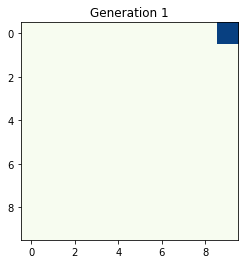

In [285]:
s.update()
s.get_grid()
s.plotgrid()

In [291]:
np.any(s.cells)